# Supermodelling

The goal of this exercise is to compare modelling with data assimilation to supermodelling.

We want to fit one model, and then try to compare its performance to supermodel made of 3 different models.

### Set up the complex system

We use lotka volterra model with 3 dynamic variables - population, intermediate predator population and apex predator population as x, y, and z

In [1]:
from scipy.integrate import odeint
import numpy as np


def lotka_volterra(vars, t, *params):
    alpha, beta, delta, gamma, epsilon, eta, zeta = params
    x, y, z = vars
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y - epsilon * y * z
    dzdt = eta * y * z - zeta * z
    return [dxdt, dydt, dzdt]


# model to return values of the system at samples_t points in time for given params
def lotka_volterra_sampler(
    samples_t,
    *params,
):

    alpha, beta, delta, gamma, epsilon, eta, zeta, x0, y0, z0 = params

    initial_values = [x0, y0, z0]

    response_y = np.zeros((len(samples_t), len(initial_values)))

    for i in np.arange(0, len(samples_t)):
        if samples_t[i] == 0.0:  # should include a decimal
            response_y[i, :] = np.array(initial_values)
        else:
            t_span = np.linspace(0.0, samples_t[i], 100)
            ySoln = odeint(
                lotka_volterra,
                initial_values,
                t_span,
                args=tuple(params[:-3]),
            )
            response_y[i, :] = ySoln[-1, :]

    return np.ravel(np.transpose(response_y))

---

# Initialize target parameters

Create a time range axis. We'll use it to create plots for the purpose of visualization

In [2]:
t_axis = np.linspace(0, 30, 6001)

axis_for_plotting = np.linspace(0, t_axis[-1], t_axis.shape[0])

# Grand truth model

We want to fit a simple model with data asimilation. But first we need a reference model that will be our reference and target. 
We'll treat it as grand truth.

Lotka volterra model naturally oscilates. It models the changes of population of different species that interact with one another.
It was hard to find a system that is not oscilating but the parameters below capture a system in which apex predator population grows over time.

In [3]:
correct_params = np.array(
    [5.0, 0.002, 0.0007, 1.0, 0.0001, 0.001, 2.3, 500.0, 35.0, 10.0]
)

y_target_response = odeint(
    func=lotka_volterra,
    y0=correct_params[-3:],
    t=axis_for_plotting,
    args=tuple(correct_params[:-3]),
)


# Prepare visualization

Create a function for plotting the complex system

In [4]:
import matplotlib.pyplot as plt


def plot_system(target, predicted=None):

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    t_axis = np.arange(target.shape[0]) / 200

    x_target, y_target, z_target = target[:, 0], target[:, 1], target[:, 2]
    ax.plot(t_axis, x_target, lw=1.5, color="b", label="grand truth prey population")
    ax.plot(
        t_axis, y_target, lw=1.5, color="g", label="grand truth predator population"
    )
    ax.plot(
        t_axis,
        z_target,
        lw=1.5,
        color="r",
        label="grand truth apex predator population",
    )

    if predicted is not None:
        x_pred, y_pred, z_pred = predicted[:, 0], predicted[:, 1], predicted[:, 2]
        ax.plot(
            t_axis,
            x_pred,
            lw=1.5,
            color="b",
            label="predicted prey population",
            linestyle="dashed",
        )
        ax.plot(
            t_axis,
            y_pred,
            lw=1.5,
            color="g",
            label="predicted predator population",
            linestyle="dashed",
        )
        ax.plot(
            t_axis,
            z_pred,
            lw=1.5,
            color="r",
            label="predicted apex predator population",
            linestyle="dashed",
        )

    plt.axvline(x=10, color="black", linestyle="dotted")
    plt.axvline(x=15, color="black", linestyle="dotted")

    ax.set_title("Population over Time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Population")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

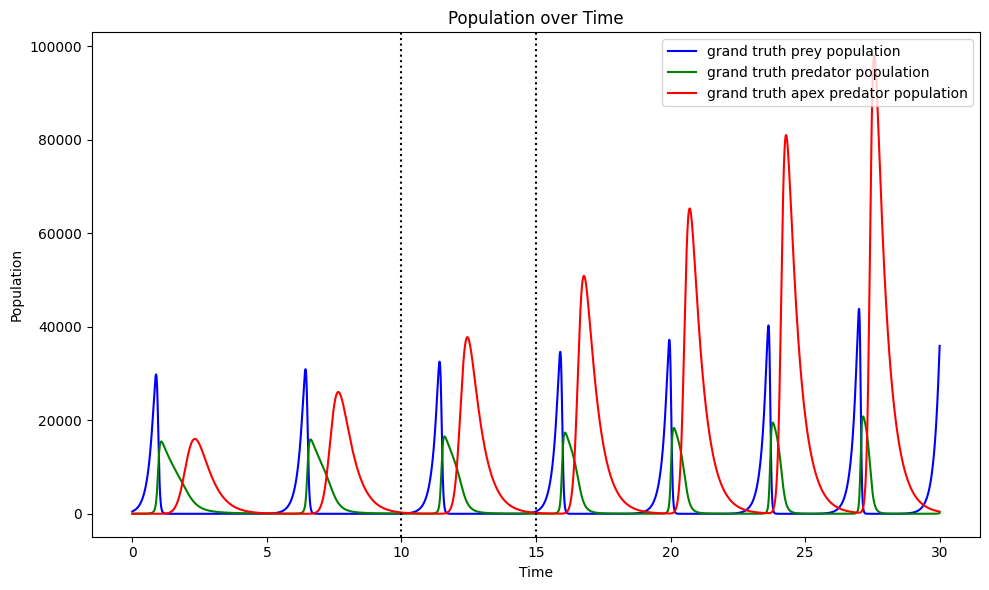

In [5]:
plot_system(y_target_response)

# Get a simple fitted model for comparison with supermodelling

Sample a few data points and their "correct" responses in range 5-10

In [6]:
sampling_idx = np.arange(0, 3001, 100)[20:31]
t_samples = t_axis[sampling_idx]
y_samples = np.ravel(np.transpose(y_target_response[sampling_idx]))

# Fit the simple model.

We fit the simple model. Finding starting parameters that don't result in numerical errors and overflows proved to be extremely difficult. Practically all stronger deviations from the correct parameters resulted in completely broken simulation

In [7]:
from scipy.optimize import curve_fit

reference_starting_params = np.array(
    [5.01, 0.00201, 0.0007, 0.90, 0.00012, 0.001, 2.3, 500.0, 35.0, 10.0]
)

predicted_ref_model_params, _ = curve_fit(
    lotka_volterra_sampler, t_samples, y_samples, p0=reference_starting_params
)

y_pred_ref_responses = odeint(
    lotka_volterra,
    predicted_ref_model_params[-3:],
    axis_for_plotting,
    args=tuple(predicted_ref_model_params[:-3]),
)

In [8]:
import pandas as pd

param_names = [
    "alpha",
    "beta",
    "delta",
    "gamma",
    "epsilon",
    "eta",
    "zeta",
    "x0",
    "y0",
    "z0",
]

df_params = pd.DataFrame(index=param_names)
df_params["starting"] = reference_starting_params
df_params["predicted"] = predicted_ref_model_params
df_params["target"] = correct_params
df_params

,starting,predicted,target
alpha,5.01000,4.688329,5.0000
beta,0.00201,0.002172,0.0020
delta,0.00070,0.000732,0.0007
gamma,0.90000,0.554624,1.0000
epsilon,0.00012,0.000146,0.0001
eta,0.00100,0.001014,0.0010
zeta,2.30000,2.031017,2.3000
x0,500.00000,655.768738,500.0000
y0,35.00000,31.901563,35.0000
z0,10.00000,20.919612,10.0000


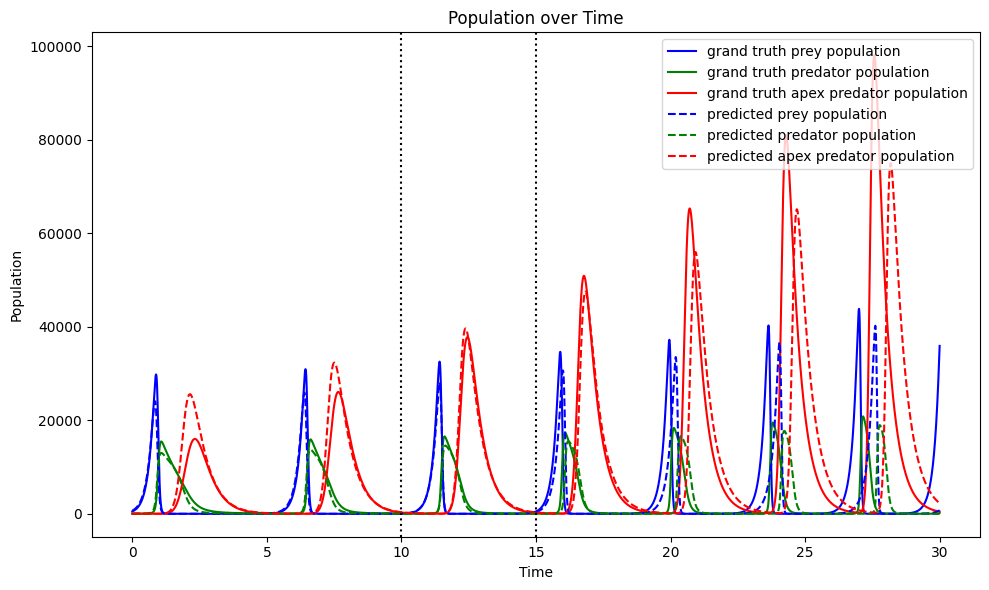

In [9]:
plot_system(y_target_response, y_pred_ref_responses)

Let us check the RMS of the prediction

In [10]:
np.sqrt(np.square(y_target_response - y_pred_ref_responses).mean())

10253.43452583144

We get a roughly good reference prediction without supermodelling. The model is able to find parameters that match the samples within the given scope [10;15]

# Initialize 3 models with different starting conditions

As we don't use the ABC method we train 3 different models using different starting conditions.

In the case of our model, it was very hard to find conditions that didn't ruin the simulation. 
In the end we kept the initial population values the same as in the reference model.

We fit all 3 models

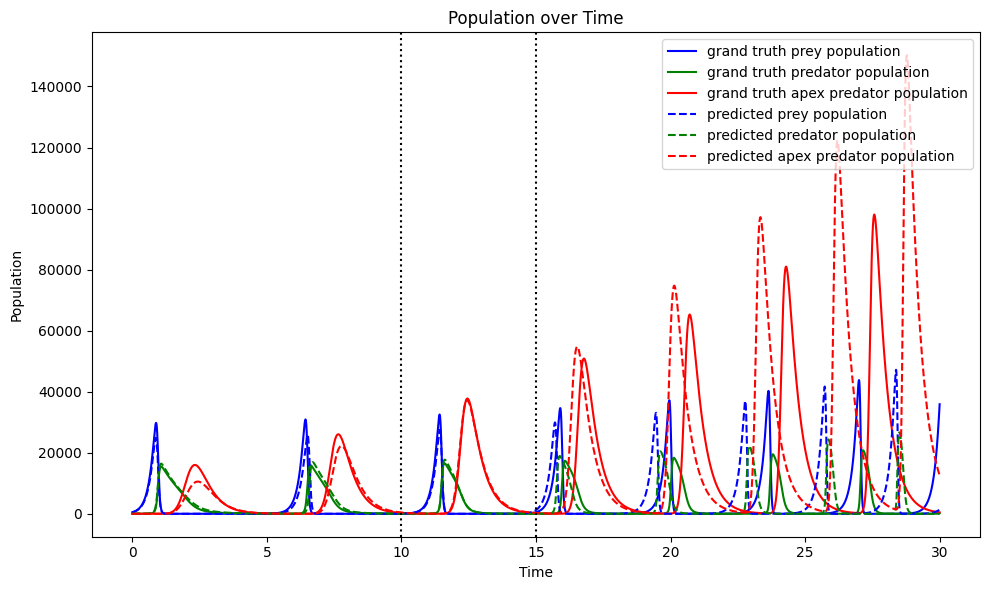

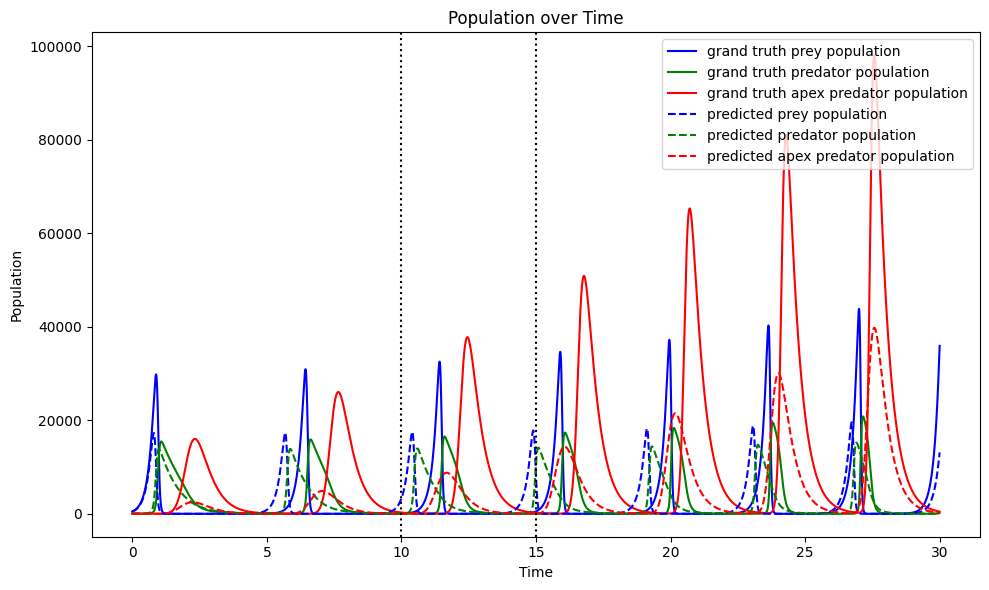

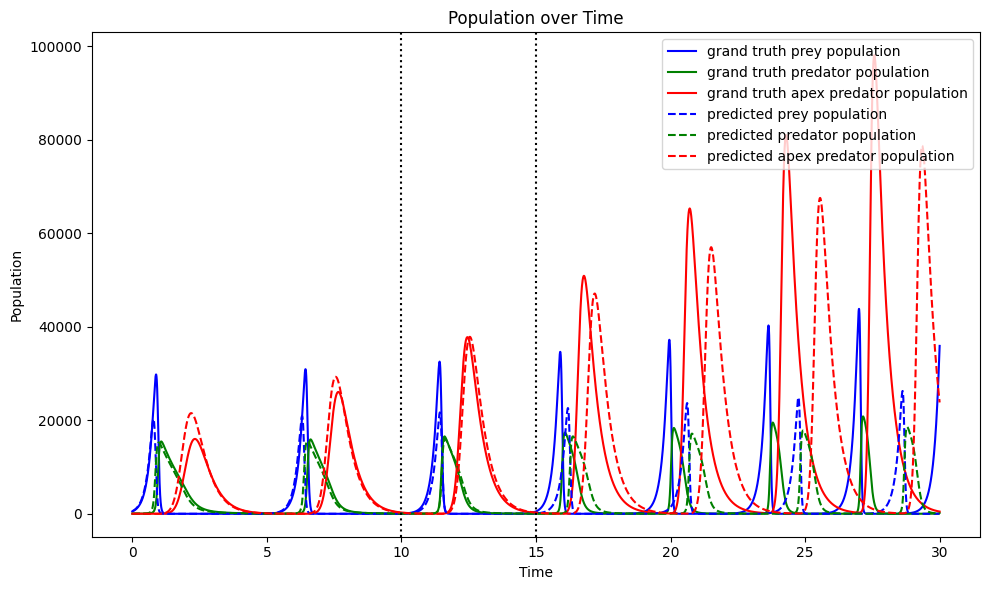

In [11]:
from scipy.optimize import curve_fit

supermodelling_starting_points = np.array(
    [
        [4.99, 0.001999, 0.0006, 1.1, 0.00015, 0.001, 2.3, 500.0, 35.0, 10.0],
        [5.01, 0.00201, 0.0007, 0.90, 0.00012, 0.00105, 2.4, 500.0, 35.0, 10.0],
        [5.01, 0.002, 0.00071, 0.90, 0.00009, 0.001, 2.298, 500.0, 35.0, 10.0],
    ]
)

supermodelling_pred_params = []
supermodelling_responses = []

for sp in supermodelling_starting_points:
    predicted_params, _ = curve_fit(lotka_volterra_sampler, t_samples, y_samples, p0=sp)
    supermodelling_pred_params.append(predicted_params)

    y_pred_ref_responses = odeint(
        lotka_volterra,
        predicted_params[-3:],
        axis_for_plotting,
        args=tuple(predicted_params[:-3]),
    )
    supermodelling_responses.append(y_pred_ref_responses)

    plot_system(y_target_response, y_pred_ref_responses)

We have 3 models that differ in their predictions
- The first one results in lower past predictions and too early future predictions
- The 2nd one is not fitted well
- The third one results in higher past predictions and too late future predictions - opposite to the first one

In [12]:
param_names = [
    "alpha",
    "beta",
    "delta",
    "gamma",
    "epsilon",
    "eta",
    "zeta",
    "x0",
    "y0",
    "z0",
]

df_params = pd.DataFrame(index=param_names)
df_params["reference_model"] = predicted_ref_model_params
df_params[["super1", "super2", "super3"]] = np.stack(supermodelling_pred_params).T
df_params["target"] = correct_params
df_params

,reference_model,super1,super2,super3,target
alpha,4.688329,4.897832,4.982978,4.997196,5.0000
beta,0.002172,0.001790,0.002025,0.002004,0.0020
delta,0.000732,0.000799,0.001126,0.000999,0.0007
gamma,0.554624,1.058202,1.385673,0.920680,1.0000
epsilon,0.000146,0.000097,0.000088,0.000090,0.0001
eta,0.001014,0.000884,0.001046,0.000995,0.0010
zeta,2.031017,2.159401,2.411591,2.346589,2.3000
x0,655.768738,482.380442,468.374602,558.606400,500.0000
y0,31.901563,44.748353,56.810179,34.900779,35.0000
z0,20.919612,8.548184,9.123664,12.420216,10.0000


We can see differences in the parameter values of each model. It's a good sign, as we want the sub-models of a supermodel to differ from one another.

# Build a supermodel

We need to build a supermodel out of our three components that we trained from different points than the reference model trained purely with data asimilation.

We use the z variable (apex predator population) to connect sub-models of the supermodel. 

In [13]:
initial_params = np.stack(supermodelling_pred_params).T.flatten()

In [14]:
def super_lotka_volterra(vars, t, *params):
    (
        alpha1,
        alpha2,
        alpha3,
        beta1,
        beta2,
        beta3,
        delta1,
        delta2,
        delta3,
        gamma1,
        gamma2,
        gamma3,
        epsilon1,
        epsilon2,
        epsilon3,
        eta1,
        eta2,
        eta3,
        zeta1,
        zeta2,
        zeta3,
    ) = initial_params[:-9]

    C12, C13, C21, C23, C31, C32 = params

    x1, x2, x3, y1, y2, y3, z1, z2, z3 = vars

    dxdt1 = alpha1 * x1 - beta1 * x1 * y1
    dydt1 = (
        delta1 * x1 * y1
        - gamma1 * y1
        - epsilon1 * y1 * z1
        + C12 * (y2 - y1)
        + C13 * (y3 - y1)
    )
    dzdt1 = eta1 * y1 * z1 - zeta1 * z1

    dxdt2 = alpha1 * x2 - beta1 * x2 * y2
    dydt2 = (
        delta1 * x2 * y2
        - gamma2 * y2
        - epsilon1 * y2 * z2
        + C21 * (y1 - y2)
        + C23 * (y3 - y2)
    )
    dzdt2 = eta2 * y2 * z2 - zeta2 * z2

    dxdt3 = alpha3 * x3 - beta3 * x3 * y3
    dydt3 = (
        delta3 * x3 * y3
        - gamma3 * y3
        - epsilon3 * y3 * z3
        + C31 * (y1 - y3)
        + C32 * (y2 - y3)
    )
    dzdt3 = eta3 * y3 * z3 - zeta3 * z3
    return [dxdt1, dxdt2, dxdt3, dydt1, dydt2, dydt3, dzdt1, dzdt2, dzdt3]


# model to return values of the system at samples_t points in time for given params
def super_lotka_volterra_sampler(
    samples_t,
    *params,
):

    initial_values = initial_params[-9:]

    response_y = np.zeros((len(samples_t), len(initial_values)))

    for i in np.arange(0, len(samples_t)):
        if samples_t[i] == 0.0:  # should include a decimal
            response_y[i, :] = np.array(initial_values)
        else:
            t_span = np.linspace(0.0, samples_t[i], 100)
            ySoln = odeint(
                super_lotka_volterra, initial_values, t_span, args=tuple(params)
            )
            response_y[i, :] = ySoln[-1, :]

    response = np.hstack(
        [
            response_y[:, 0:3].mean(axis=-1, keepdims=True),
            response_y[:, 3:6].mean(axis=-1, keepdims=True),
            response_y[:, 6:9].mean(axis=-1, keepdims=True),
        ]
    )

    return np.ravel(np.transpose(response))

# Fit the supermodel

In [15]:
super_starting_params = np.array([0, 0, 0, 0, 0, 0])

supermodel_params, _ = curve_fit(
    super_lotka_volterra_sampler, t_samples, y_samples, p0=super_starting_params
)

super_y = odeint(
    super_lotka_volterra,
    initial_params[-9:],
    axis_for_plotting,
    args=tuple(supermodel_params),
)

super_y = np.hstack(
    [
        super_y[:, 0:3].mean(axis=-1, keepdims=True),
        super_y[:, 3:6].mean(axis=-1, keepdims=True),
        super_y[:, 6:9].mean(axis=-1, keepdims=True),
    ]
)

# Compare the target model to the supermodel and simple data assimilation model

Simple data assimilation reference model


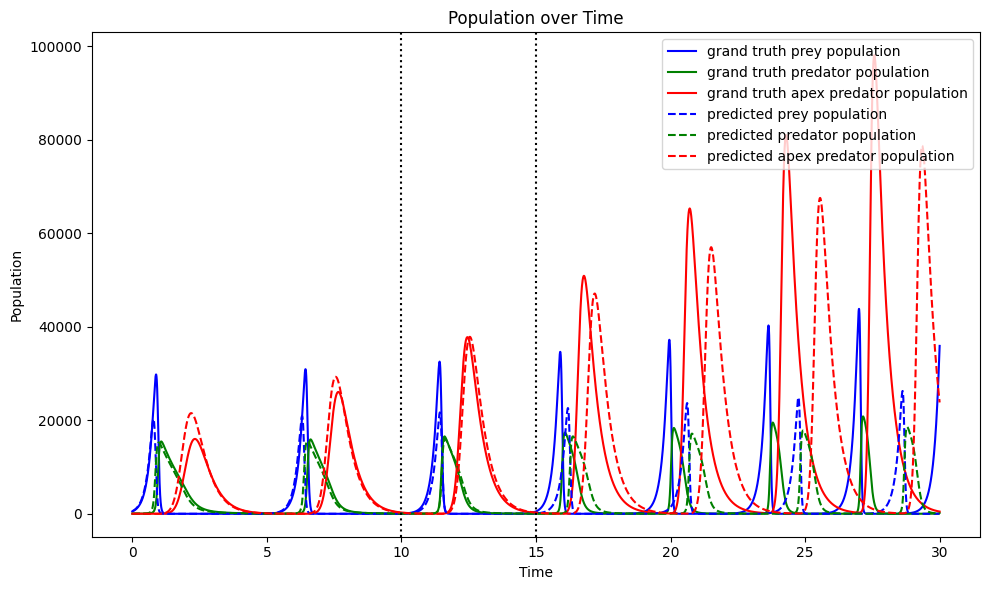

Supermodel


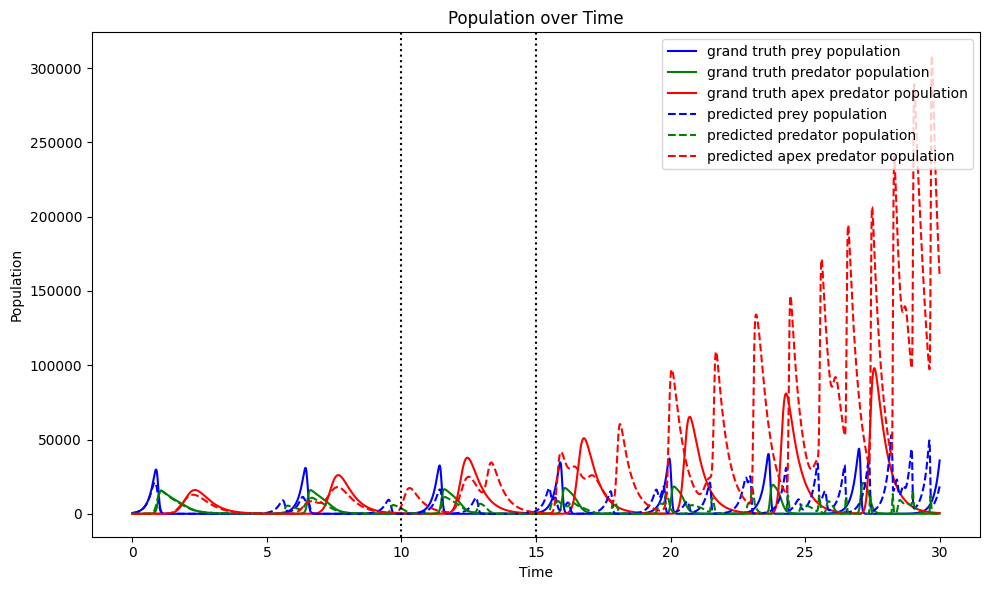

In [16]:
print("Simple data assimilation reference model")
plot_system(y_target_response, y_pred_ref_responses)

print("Supermodel")
plot_system(y_target_response, super_y)

In [17]:
print(
    "Simple data assimilation - RMS:",
    np.sqrt(np.square(y_target_response - y_pred_ref_responses).mean()),
)
print(
    "Supermodel               - RMS:",
    np.sqrt(np.square(y_target_response - super_y).mean()),
)

Simple data assimilation - RMS: 14125.748429360608
Supermodel               - RMS: 34029.8471457019


We can see that the supermodel performed very poorly compared to the original. Maybe connecting the models via different variables will allow us to get better results?

# Connecting supermodel via different variables

This time lets try connecting the models differently.

- We connect the first model to the other two by x variable
- We connect the second model to the other two by y variable
- We connect the third model to the other two by z variable

In [18]:
def super_lotka_volterra_2(vars, t, *params):
    (
        alpha1,
        alpha2,
        alpha3,
        beta1,
        beta2,
        beta3,
        delta1,
        delta2,
        delta3,
        gamma1,
        gamma2,
        gamma3,
        epsilon1,
        epsilon2,
        epsilon3,
        eta1,
        eta2,
        eta3,
        zeta1,
        zeta2,
        zeta3,
    ) = initial_params[:-9]

    C12, C13, C21, C23, C31, C32 = params

    x1, x2, x3, y1, y2, y3, z1, z2, z3 = vars

    # connect the first model to the other two via x variable
    dxdt1 = alpha1 * x1 - beta1 * x1 * y1 + C12 * (x2 - x1) + C13 * (x3 - x1)
    dydt1 = delta1 * x1 * y1 - gamma1 * y1 - epsilon1 * y1 * z1
    dzdt1 = eta1 * y1 * z1 - zeta1 * z1

    # connect the second model to the other two via y variable
    dxdt2 = alpha1 * x2 - beta1 * x2 * y2
    dydt2 = (
        delta1 * x2 * y2
        - gamma2 * y2
        - epsilon1 * y2 * z2
        + C21 * (y1 - y2)
        + C23 * (y3 - y2)
    )
    dzdt2 = eta2 * y2 * z2 - zeta2 * z2

    # connect the third model to the other two via z variable
    dxdt3 = alpha3 * x3 - beta3 * x3 * y3
    dydt3 = delta3 * x3 * y3 - gamma3 * y3 - epsilon3 * y3 * z3
    dzdt3 = eta3 * y3 * z3 - zeta3 * z3 + C31 * (z1 - z3) + C32 * (z2 - z3)

    return [dxdt1, dxdt2, dxdt3, dydt1, dydt2, dydt3, dzdt1, dzdt2, dzdt3]


# model to return values of the system at samples_t points in time for given params
def super_lotka_volterra_sampler_2(
    samples_t,
    *params,
):

    initial_values = initial_params[-9:]

    response_y = np.zeros((len(samples_t), len(initial_values)))

    for i in np.arange(0, len(samples_t)):
        if samples_t[i] == 0.0:  # should include a decimal
            response_y[i, :] = np.array(initial_values)
        else:
            t_span = np.linspace(0.0, samples_t[i], 100)
            ySoln = odeint(
                super_lotka_volterra_2, initial_values, t_span, args=tuple(params)
            )
            response_y[i, :] = ySoln[-1, :]

    response = np.hstack(
        [
            response_y[:, 0:3].mean(axis=-1, keepdims=True),
            response_y[:, 3:6].mean(axis=-1, keepdims=True),
            response_y[:, 6:9].mean(axis=-1, keepdims=True),
        ]
    )

    return np.ravel(np.transpose(response))

# Fit the supermodel

In [19]:
super_starting_params = np.array([0, 0, 0, 0, 0, 0])

supermodel_params, _ = curve_fit(
    super_lotka_volterra_sampler_2, t_samples, y_samples, p0=super_starting_params
)

super_y = odeint(
    super_lotka_volterra_2,
    initial_params[-9:],
    axis_for_plotting,
    args=tuple(supermodel_params),
)

super_y = np.hstack(
    [
        super_y[:, 0:3].mean(axis=-1, keepdims=True),
        super_y[:, 3:6].mean(axis=-1, keepdims=True),
        super_y[:, 6:9].mean(axis=-1, keepdims=True),
    ]
)

# Comparison with target data and data assimilation model

Supermodel


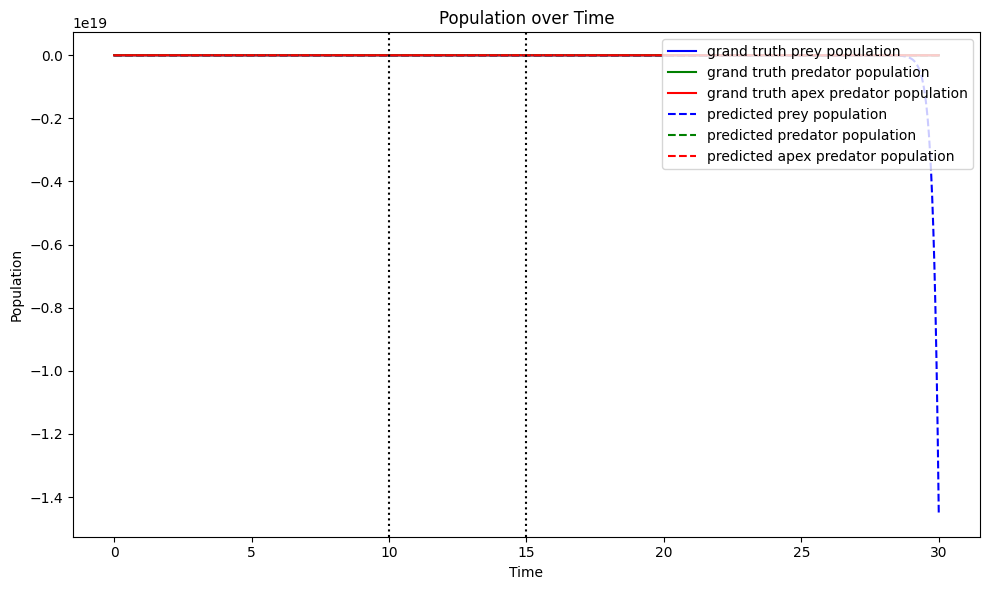

In [20]:
print("Supermodel")
plot_system(y_target_response, super_y)

We can see that one of the supermodel values exploded. Let's try to see if closer range approximates the actual model well.

But maybe the model works well in a shorter range? Let's see. We'll show again the reference model (simple data assimilation) and supermodel compared to the true samples

Simple data assimilation reference model


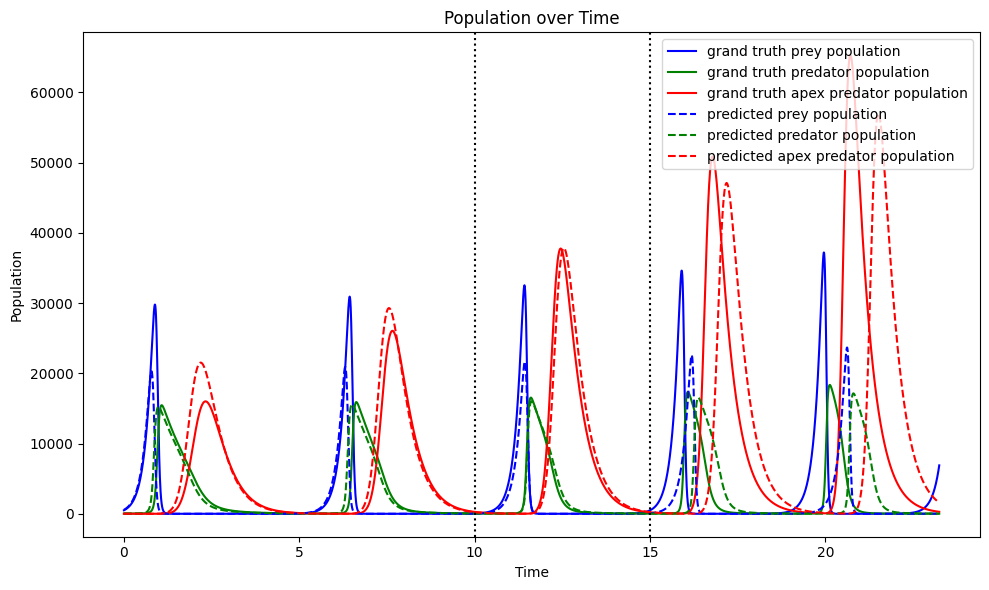

Supermodel


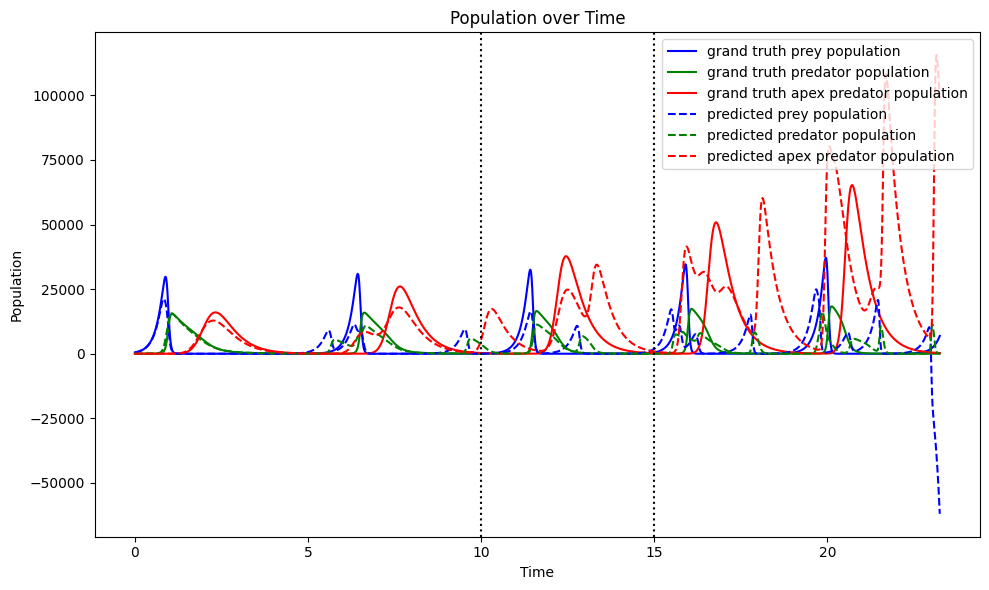

In [24]:
print("Simple data assimilation reference model")
plot_system(y_target_response[:4650], y_pred_ref_responses[:4650])

print("Supermodel")
plot_system(y_target_response[:4650], super_y[:4650])

In [25]:
print(
    "Simple data assimilation - RMS:",
    np.sqrt(np.square(y_target_response[:4650] - y_pred_ref_responses[:4650]).mean()),
)
print(
    "Supermodel               - RMS:",
    np.sqrt(np.square(y_target_response[:4650] - super_y[:4650]).mean()),
)

Simple data assimilation - RMS: 8272.604446668836
Supermodel               - RMS: 13243.022170180424


Unfortunately we didn't manage to improve the performance of the supermodel. by connecting it via different parameters

---

# Conclusion

- We performed data assimilation of a  simple model.
- We created 3 sub-models and also performed data assimilation.
- We built a supermodel out of the three sub-models connected via one variable. We assessed the supermodel performance against grand truth and reference model.
- We built a supermodel out of three sub-models by connecting them by three separate variables. We assessed the supermodel performance against grand truth and reference model.

Turns out that in case of 3 variable lotka volterra model, data assimilation worked better than supermodelling.

We can try to explain this by the fact that very few sets of parameters of our model result in system without errors. 
Even for a human, finding parameters for one model that don't ruin the simulation proved to be very dificult.
It's highly probable that assimilation of the values connecting the sub-models simply found too many chaotic parameters.